In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import json
from utils import dref_dataframe

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_logs(path: Path, iter: int = 1) -> pd.DataFrame:
    datas = []
    for i in range(iter):
        data = pd.read_csv(path / f"out_{i}.csv")
        meta = json.load((path / f"meta.json").open())
        data["iter"] = i
        data["shrink"] /= 1e9 / meta["args"]["mem"]
        data["grow"] /= 1e9 / meta["args"]["mem"]
        datas.append(data)
    data = pd.concat(datas)
    match path.stem.split("-", 1)[1].replace("-manual", "").replace("-movable", ""):
        case "base": mode = "virtio-balloon"
        case "huge": mode = "virtio-huge"
        case "llfree": mode = "llfree-balloon"
        case "llfree-vfio": mode = "llfree-balloon-vfio"
        case "huge": mode = "virtio-huge"
        case m: mode = m
    data["mode"] = mode
    return pd.DataFrame(data)


       shrink       grow  iter                 mode
0  165.267768  91.716907     0       virtio-balloon
0  220.789896  92.118645     1       virtio-balloon
0  228.671669  91.961393     2       virtio-balloon
0    1.437399   0.655684     0          virtio-huge
0    1.416194   0.655904     1          virtio-huge
0    1.430236   0.654219     2          virtio-huge
0    8.173390   2.005209     0           virtio-mem
0    5.869173   1.963983     1           virtio-mem
0    5.903656   2.018279     2           virtio-mem
0   11.196264  44.410284     0      virtio-mem-vfio
0    9.088388  44.604823     1      virtio-mem-vfio
0    9.146374  44.676552     2      virtio-mem-vfio
0    0.599825   0.026115     0       llfree-balloon
0    0.671734   0.026227     1       llfree-balloon
0    0.674733   0.026360     2       llfree-balloon
0    3.829546   0.026114     0  llfree-balloon-vfio
0    3.931040   0.026706     1  llfree-balloon-vfio
0    3.818660   0.026218     2  llfree-balloon-vfio


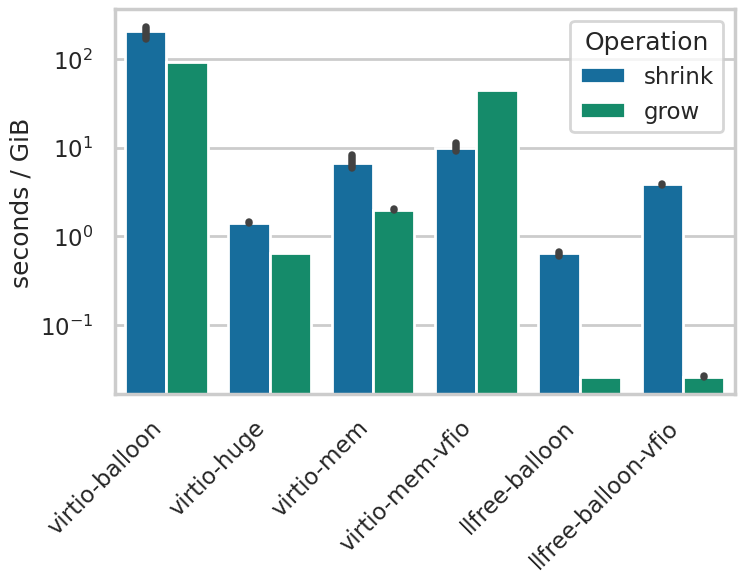

In [4]:
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]
data = pd.concat([parse_logs(p, 3) for p in paths])
print(data)

plt.figure(figsize=(8, 5))
pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
p = sns.barplot(pgd, y="time", x="mode", hue="op")
p.legend(title="Operation")
p.set_yscale("log")
p.set_ylabel("seconds / GiB")
p.set_xlabel(None)
_ = p.set_xticklabels(p.get_xticklabels(), rotation=45, ha="right")
p.figure.savefig("inflate/inflate.pdf", bbox_inches="tight")
dref_dataframe("inflate", Path("inflate"), ["mode", "iter", "op"], pgd)

       shrink       grow  iter                 mode
0  165.267768  91.716907     0       virtio-balloon
0  220.789896  92.118645     1       virtio-balloon
0  228.671669  91.961393     2       virtio-balloon
0    1.437399   0.655684     0          virtio-huge
0    1.416194   0.655904     1          virtio-huge
0    1.430236   0.654219     2          virtio-huge
0    8.173390   2.005209     0           virtio-mem
0    5.869173   1.963983     1           virtio-mem
0    5.903656   2.018279     2           virtio-mem
0   11.196264  44.410284     0      virtio-mem-vfio
0    9.088388  44.604823     1      virtio-mem-vfio
0    9.146374  44.676552     2      virtio-mem-vfio
0    0.599825   0.026115     0       llfree-balloon
0    0.671734   0.026227     1       llfree-balloon
0    0.674733   0.026360     2       llfree-balloon
0    3.829546   0.026114     0  llfree-balloon-vfio
0    3.931040   0.026706     1  llfree-balloon-vfio
0    3.818660   0.026218     2  llfree-balloon-vfio


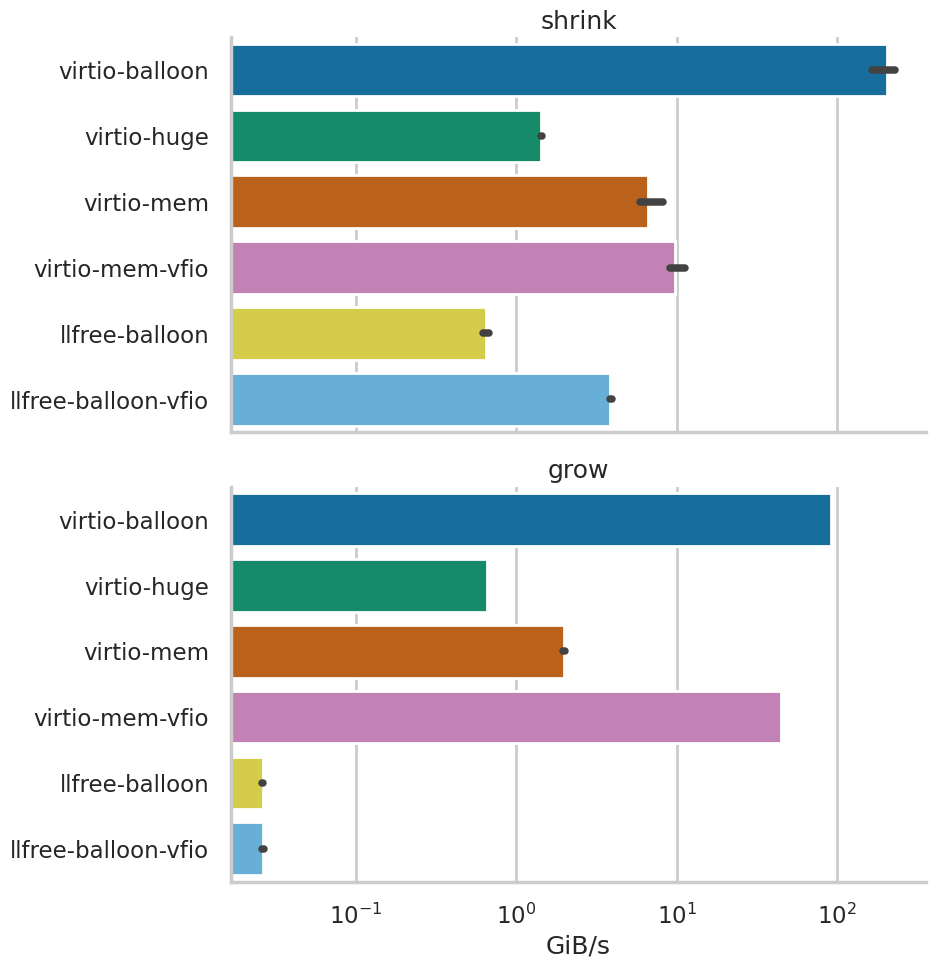

In [30]:
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
print(data)

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
p = sns.catplot(pgd, kind="bar", y="mode", x="time", row="op", legend=False, aspect=2)
p.set(xscale="log")
p.set(xlabel="GiB/s")
p.set(ylabel=None)
p.set_titles(row_template="{row_name}")